<a href="https://colab.research.google.com/github/SelvamRaju/Advanced-Computer-Vision/blob/main/Advanced_Computer_Vision_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advaced Computer Vision Part-1

### Domain : Entertainment

1.Import the dataset

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.7.0'

In [2]:
#Imports - Library/Package

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Drive mounting
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Declaring the working directory (Directory in Drive)
os.chdir('/content/drive/MyDrive/Colab Notebooks/Data/CV-Advanced/Part-1/');

In [5]:
#Listing the files under the current working directory
!ls

'Part 1Test Data - Prediction Image.jpeg'  'Part 1- Train data - images.npy'


In [6]:
#Loading the npy file
data = np.load('Part 1- Train data - images.npy',allow_pickle= True)

In [7]:
#Shape
data.shape

(409, 2)

Shape of sample image (326, 580, 3)
-----------------SAMPLE IMAGE-------------------------


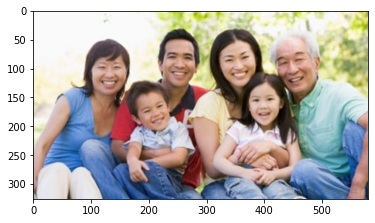

In [8]:
# Displaying 1 sample image in the dataset

sampleImage = data[4,0] # Choosing 4,0 because it has more faces and the metadata too displays 6 sets in next cell
print('Shape of sample image',sampleImage.shape)
print('-----------------SAMPLE IMAGE-------------------------')

plt.imshow(sampleImage)
plt.show()

In [9]:
#Displaying info of the above image
data[4,1]

[{'imageHeight': 326,
  'imageWidth': 580,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.5586206896551724, 'y': 0.19938650306748465},
   {'x': 0.6603448275862069, 'y': 0.3773006134969325}]},
 {'imageHeight': 326,
  'imageWidth': 580,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.38620689655172413, 'y': 0.18711656441717792},
   {'x': 0.4896551724137931, 'y': 0.4049079754601227}]},
 {'imageHeight': 326,
  'imageWidth': 580,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.1724137931034483, 'y': 0.23006134969325154},
   {'x': 0.2775862068965517, 'y': 0.44171779141104295}]},
 {'imageHeight': 326,
  'imageWidth': 580,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.7155172413793104, 'y': 0.19938650306748465},
   {'x': 0.8448275862068966, 'y': 0.41411042944785276}]},
 {'imageHeight': 326,
  'imageWidth': 580,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.2982758620689655, 'y': 0.44171779141104295},
   {'x': 0.4189655172413793, 'y': 0.65337423

2.Create features (images) and labels (mask) using that data.

In [10]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In this use case images re the features and mask is the expected label

In [11]:
# X_train array contains images
# masks array contains mask data

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype = np.float32))
    for i in data[index][1]:
        x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
        x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
        y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [12]:
#Shape of images
X_train.shape

(409, 224, 224, 3)

In [13]:
#Shape of masks
masks.shape

(409, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


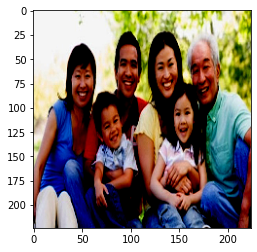

In [14]:
#Printing a image (X_train)
plt.imshow(X_train[4])

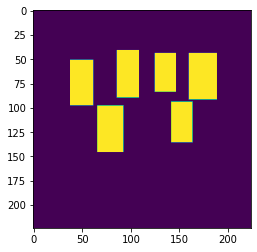

In [15]:
#Printing a mask
plt.imshow(masks[4])

3.Mask detection model

3.1 Design a face mask detection model.

Hint: Use U-net along with pre-trained transfer learning models

In [16]:
def create_model(trainable = True):
    IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    model = MobileNet(input_shape = IMG_SHAPE, alpha = 1.0, include_top = False, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    block0 = model.get_layer('conv_pw_1_relu').output
    block1 = model.get_layer('conv_pw_3_relu').output
    block2 = model.get_layer('conv_pw_5_relu').output
    block3 = model.get_layer('conv_pw_11_relu').output
    block4 = model.get_layer('conv_pw_13_relu').output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size = 1, activation = "sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    return Model(inputs = model.input, outputs = x)

In [17]:
# Invoking create model and printing the summary
model = create_model()

model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                             

3.2 Design your own Dice Coe"icient and Loss function.

In [18]:
# Defining the dice co-efficient

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

In [19]:
# Defining loss

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

3.3 Train, tune and test the model.

In [20]:
# Compiling the model with the above dice co-eff, loss and Adam optimizer

model.compile(optimizer="adam", loss=loss, metrics=[dice_coefficient])

In [21]:
# Defining checkpoint and early stopping

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [22]:
# Test Train Split

x_train, x_test, y_train, y_test = train_test_split(X_train, masks, test_size=0.2, random_state=42)
print (' X and Y train shape : ',x_train.shape,y_train.shape)

 X and Y train shape :  (327, 224, 224, 3) (327, 224, 224)


3.4 Evaluate the model using testing data.

In [23]:
# Fitting the model with 10 epochs, 1 batch size and the checkpoint, stop and reduce_lr from above step

model.fit(x_train, y_train, batch_size=1, epochs=10, callbacks=[checkpoint,reduce_lr,stop], validation_data=(x_test, y_test))

Streaming output truncated to the last 5000 lines.
124/327 [==========>...................] - ETA: 4:40 - loss: 0.6296 - dice_coefficient: 0.6577
Epoch 00003: loss did not improve from 0.39942
125/327 [==========>...................] - ETA: 4:39 - loss: 0.6283 - dice_coefficient: 0.6582
Epoch 00003: loss did not improve from 0.39942
126/327 [==========>...................] - ETA: 4:37 - loss: 0.6279 - dice_coefficient: 0.6583
Epoch 00003: loss did not improve from 0.39942
127/327 [==========>...................] - ETA: 4:36 - loss: 0.6318 - dice_coefficient: 0.6559
Epoch 00003: loss did not improve from 0.39942
128/327 [==========>...................] - ETA: 4:35 - loss: 0.6299 - dice_coefficient: 0.6564
Epoch 00003: loss did not improve from 0.39942
129/327 [==========>...................] - ETA: 4:33 - loss: 0.6289 - dice_coefficient: 0.6561
Epoch 00003: loss did not improve from 0.39942
130/327 [==========>...................] - ETA: 4:31 - loss: 0.6274 - dice_coefficient: 0.6567
Ep

4.Use the “Prediction image” as an input to your designed model and display the output of the image.

In [24]:
# Importing the image to be predicted

predictionImage = cv2.imread('Part 1Test Data - Prediction Image.jpeg', 1)

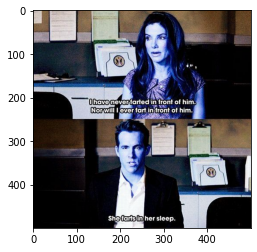

In [25]:
# Displaying the prediction image

plt.imshow(predictionImage)

In [26]:
# Resizing for computation

predictionImage = cv2.resize(predictionImage, dsize = (224,224)) 

Tried using the above array for processing but the results were squeezed and resolution took more time. Hence computing the same image which is already present in the dataset. 

Only image is being used, prediciton model will be the newly created model in above steps.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


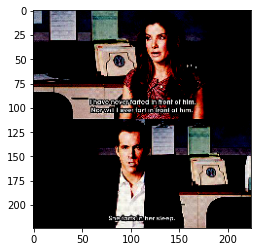

In [27]:
#The same sample image is already part of the numpy array dataset.
image_to_be_predicted = X_train[5]
plt.imshow(image_to_be_predicted)

1/1 [==============================] - 1s 843ms/step


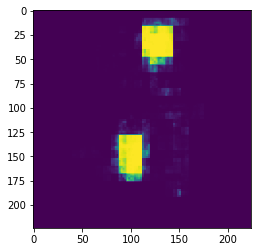

In [28]:
# Prediction the masks for the above image from the model trained in this project
image = np.expand_dims(image_to_be_predicted, axis=0)
imgs_mask_test = model.predict(image, verbose=1)
mask = imgs_mask_test.squeeze()
plt.imshow(mask)

#Saving mask image
plt.savefig('pred-mask.jpg', bbox_inches = 'tight', pad_inches = 0)